In [1]:
# ----------------------------------------------------------------------------*
# SEIS 764 Artificial Intelligence
# Assignment 5 : Transfer learning 
# Visual Geometry Group (VGG16) & Inception v3)
# auther: Yann Mulonda - November 7, 2021
# ----------------------------------------------------------------------------*
# Import the libraries needed
import numpy as np
import pandas as pd
from glob import glob
import sys, os, zipfile
import tensorflow as tf
from google.colab import auth
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam
from oauth2client.client import GoogleCredentials
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input


In [2]:
# check which runtime GPU I'm using
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# ----------------------------------------------------------------------------*
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# Download the zip file saved in the Drive 
!pip install -U -q PyDrive

#File ID
zip_id = '1sajk-SXeemD-0JXDoTMezv3hlvoHUi4v'

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the zip file
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('flowers.zip')

# verified that the data has been downloaded
!ls

adc.json  flowers.zip  sample_data


In [4]:
# let's unzip the data
# -qq don't show ouput
!unzip -qq -o flowers.zip

In [5]:
# Show unzip data
!ls

adc.json  flowers.zip  roses_and_tulips  sample_data


In [6]:
# Show unzip data
!ls roses_and_tulips

roses  tulips


In [7]:
# show rose data
# !ls roses_and_tulips/roses/

In [8]:
# show tulips data
# !ls roses_and_tulips/tulips/

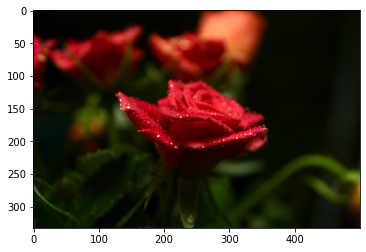

In [9]:
# Show sample rose data: check out an image
plt.imshow(image.load_img('roses_and_tulips/roses/3630246240_4fee9a33db.jpg'))
plt.show()

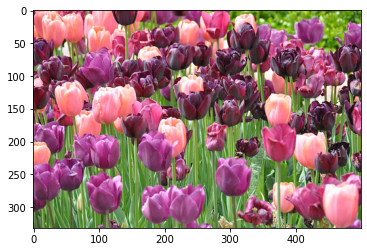

In [10]:
# Show sample tulips data: check out an image
plt.imshow(image.load_img('roses_and_tulips/tulips/5682463466_d3e641cb8b.jpg'))
plt.show()

In [11]:
# now let's set up the proper directory structure
# let start with creating the appropriate directories
# Make appropriate directories 
!mkdir data                           
!mkdir data/train
!mkdir data/test
!mkdir data/train/roses
!mkdir data/train/tulips
!mkdir data/test/roses
!mkdir data/test/tulips

In [12]:
# ----------------------------------------------------------------------------*
# show how many images storein a folder path
def howmanyImages(images_path):
  import glob
  images = glob.glob(images_path + '/*.jpg')
  count = 0
  for image in images:
    count = count + 1
    
  print(count, "images counted in", images_path)

# ----------------------------------------------------------------------------*
# map the data into feature vectors
def performTransferLearning(IMAGE_SIZE, ptm, augmentation=False):

  # STAGE 1
  # We'll use the ptm we defined both for VGG16 instance and inceptionV3

  # let's freeze the VGG16 and inceptionV3 instance created on stage 1 
  # for pretrained model weights
  # Note --- We can retrain some of the lower layers to increase performance
  #      --- Keep in mind that this may lead to overfitting
  # Make all the layers non-trainable 
  ptm.trainable = False

  # STAGE 2 
  # let's create our classifier
  # map the data into feature vectors
  if augmentation:
    print('-- Perform Transfer Learning with Augmentation --')
    # Keras image data generator returns classes one-hot encoded
    K = len(folders) # number of classes
    x = Flatten()(ptm.output)
    x = Dense(K, activation='softmax')(x)
  else:
    print('-- Perform Transfer Learning without Augmentation --')
    # Keras image data generator returns classes one-hot encoded
    # K = len(folders) # number of classes
    x = Flatten()(ptm.output)

  # create a model object
  # combine stage 1 -- inputs=ptm.input
  # and stage 2 -- outputs=x
  model = Model(inputs=ptm.input, outputs=x)

  return model

# ----------------------------------------------------------------------------*
# Ploting loss and Accuracy per iteration
def plotLossAndAccuracy(r):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
  # fig.suptitle('Loss and Accuracy per iteration')
  # Ploting loss
  ax1.plot(r.history['loss'], label='loss')
  ax1.plot(r.history['val_loss'], label='val_loss')
  ax1.set_title('Loss per iteration')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  # Ploting Accuracy
  ax2.plot(r.history['accuracy'], label='acc')
  ax2.plot(r.history['val_accuracy'], label='val_acc')
  ax2.set_title('Accuracy per iteration')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  fig.tight_layout()
  plt.show()

# ----------------------------------------------------------------------------*
def imageDataGenerator(IMAGE_SIZE, batch_size, model, augmentation=False):

  if augmentation:
    print('-- create an instance of ImageDataGenerator with Augmentation --')
    # create an instance of ImageDataGenerator
    # this is where we are aolso doing some of the preprocessing
    gen_train = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      preprocessing_function=preprocess_input
    )

    # we don't augment test image but we have to precess them
    gen_test = ImageDataGenerator(
      preprocessing_function=preprocess_input
    )

    # create generators
    train_generator = gen_train.flow_from_directory(
      train_path,               # this is the training data path we setup earlier
      shuffle=True,
      target_size=IMAGE_SIZE,   # image size that we define for standarization
      batch_size=batch_size,
    )
    valid_generator = gen_test.flow_from_directory(
      valid_path,               # this is the validation data path we setup earlier
      target_size=IMAGE_SIZE,   # image size that we define for standarization
      batch_size=batch_size,
    )

    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
    )

    return gen_train, gen_test, train_generator, valid_generator

  else:
    print('-- create an instance of ImageDataGenerator without Augmentation --')
    # create an instance of ImageDataGenerator
    gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # create generators
    train_generator = gen.flow_from_directory(
      train_path,
      target_size=IMAGE_SIZE,
      batch_size=batch_size,
      class_mode='binary',
    )

    valid_generator = gen.flow_from_directory(
      valid_path,
      target_size=IMAGE_SIZE,
      batch_size=batch_size,
      class_mode='binary',
    )

    return train_generator, valid_generator

# ----------------------------------------------------------------------------*
def trainModel(model, numberOfEpochs, train_generator, valid_generator,
               image_files, valid_image_files, batch_size):
  r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=numberOfEpochs,
    steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
  )

  return r
  
# ----------------------------------------------------------------------------*
# populate X_train, X_val, Y_train, Y_val
def populate(generator, model, X, Y, N):
  i = 0
  for x, y in generator:
    # get features
    features = model.predict(x)
    
    # size of the batch (may not always be batch_size)
    sz = len(y)
    
    # assign to X_train and Ytrain
    X[i:i + sz] = features
    Y[i:i + sz] = y
    
    # increment i
    i += sz
    print(i)

    if i >= N:
      print('breaking now')
      break
  print(i)

# -----------------------------------------------------------------------------*

In [13]:
# now let's move the data to the appropriate directories
# Move the images
# Note: we will use 200 images for training and the remaining 100 for testing

# 200 rose images for training 
!mv roses_and_tulips/roses/*_m.jpg data/train/roses
!mv roses_and_tulips/roses/*_n.jpg data/train/roses
!mv roses_and_tulips/roses/*14* data/train/roses
!mv roses_and_tulips/roses/1392579828_ab5a139052.jpg data/train/roses

# 200 tulips images for training 
!mv roses_and_tulips/tulips/*_m.jpg data/train/tulips
!mv roses_and_tulips/tulips/*_n.jpg data/train/tulips
!mv roses_and_tulips/tulips/*13* data/train/tulips

In [14]:
# show number of images for training
howmanyImages('data/train/roses')
howmanyImages('data/train/tulips')

200 images counted in data/train/roses
200 images counted in data/train/tulips


In [15]:
# now move the remaining 100 rose images for testing
!mv roses_and_tulips/roses/*.jpg data/test/roses

# the remaining 100 tupils images for testing
!mv roses_and_tulips/tulips/*.jpg data/test/tulips

In [16]:
# show number of images for testing
howmanyImages('data/test/roses')
howmanyImages('data/test/tulips')

100 images counted in data/test/roses
100 images counted in data/test/tulips


In [17]:
# set up path for training and validation
train_path = 'data/train'
valid_path = 'data/test'

# process the image : standarization
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [150, 150]

# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
print('Number of images for training: ', len(image_files))
print('Number of images for validation: ', len(valid_image_files))

Number of images for training:  400
Number of images for validation:  200


In [18]:
# useful for getting number of classes
folders = glob(train_path + '/*')
print(folders)

['data/train/roses', 'data/train/tulips']


In [19]:
# ----------------------------------------------------------------------------*
# VGG16:  
# • Model 1: Perform Transfer Learning with Augmentation 
# ----------------------------------------------------------------------------*
# ****** Stage 1 ********
# let's create an instance of the VVG16 using our IMAGE_SIZE
ptm_VGG16 = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

# let's build the model
model1 = performTransferLearning(IMAGE_SIZE, ptm_VGG16, augmentation=True)

# view the structure of the model
model1.summary()

58900480/58889256 [==============================] - 0s 0us/step
-- Perform Transfer Learning with Augmentation --
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________

In [20]:
# create an instance of ImageDataGenerator
# this is where we are aolso doing some of the preprocessing
# using a batch size of 128
instance = imageDataGenerator(IMAGE_SIZE, 128, model1, augmentation=True)
gen_train = instance[0] 
gen_test = instance[1]
train_generator = instance[2]
valid_generator = instance[3]

-- create an instance of ImageDataGenerator with Augmentation --
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Epoch 1/10
4/4 [==============================] - 28s 2s/step - loss: 8.5154 - accuracy: 0.5325 - val_loss: 4.3445 - val_accuracy: 0.7350
Epoch 2/10
4/4 [==============================] - 3s 863ms/step - loss: 2.9959 - accuracy: 0.7400 - val_loss: 3.3417 - val_accuracy: 0.8100
Epoch 3/10
4/4 [==============================] - 3s 850ms/step - loss: 2.6014 - accuracy: 0.7850 - val_loss: 3.0900 - val_accuracy: 0.8250
Epoch 4/10
4/4 [==============================] - 3s 1s/step - loss: 1.7574 - accuracy: 0.8550 - val_loss: 2.7134 - val_accuracy: 0.8350
Epoch 5/10
4/4 [==============================] - 3s 861ms/step - loss: 1.5555 - accuracy: 0.8900 - val_loss: 2.6594 - val_accuracy: 0.8550
Epoch 6/10
4/4 [==============================] - 3s 1s/step - loss: 1.1707 - accuracy: 0.8975 - val_loss: 2.5524 - val_accuracy: 0.8500
Epoch 7/10
4/4 [==============================] - 3s 1s/step - loss: 1.1822 - accuracy: 0.8875 - val_loss: 2.9904 - val_accuracy: 0.8600
Epoch 8/10
4/4 [===============

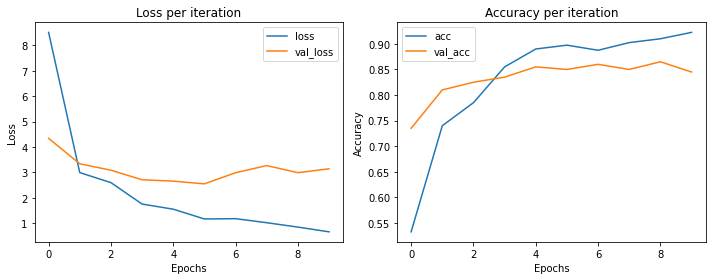

In [21]:
# Now let's train our model
# fit the model
# using a batch size of 128 and 10 epochs
r1 = trainModel(model1, 10, train_generator, valid_generator, 
                image_files, valid_image_files, 128)

# Ploting loss and Accuracy per iteration
plotLossAndAccuracy(r1)

In [22]:
# ----------------------------------------------------------------------------*
# VGG16:  
# • Model 2: Perform Transfer Learning without Augmentation 
# ----------------------------------------------------------------------------*
# let's build model 2 using the same ptm_VGG16
model2 = performTransferLearning(IMAGE_SIZE, ptm_VGG16, augmentation=False)

# view the structure of the model
model2.summary()

-- Perform Transfer Learning without Augmentation --
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2

In [23]:
# create an instance of ImageDataGenerator
# this is where we are aolso doing some of the preprocessing
# using a batch size of 128
instance2 = imageDataGenerator(IMAGE_SIZE, 128, model2)
train_generator2 = instance2[0]
valid_generator2 = instance2[1]

-- create an instance of ImageDataGenerator without Augmentation --
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [24]:
# Number of training and testing images
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

# Figure out the output size or the shape of what i'm getting out
# before flattening
feat = model2.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

# let's creat the features and targets
X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

In [25]:
# right now X_train and Y_train are just a bunch of 0s
# let's populate X_train and Y_train
populate(train_generator2, model2, X_train, Y_train, Ntrain)

128
256
384
400
breaking now
400


In [26]:
# populate X_valid and Y_valid
populate(valid_generator2, model2, X_valid, Y_valid, Nvalid)

128
200
breaking now
200


In [27]:
# let's check the value to see if normalization is going to 
# be helpfull or needed
X_train.max(), X_train.min()

(340.7490539550781, 0.0)

In [28]:
#let's now normalized the X-features data
# after normalization the mean bcome 0
# and the devioation become 1
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

# let's check again
X_train2.max(), X_train2.min()

(19.974984355438362, -1.495251591868035)

In [29]:
# Now let's try the scikit-learn logistic regression
# we are getting a high accuray from logistic regression 
# because of the power of VVG -- just running the image VVG helped
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.92


Epoch 1/10
4/4 [==============================] - 0s 39ms/step - loss: 0.7583 - accuracy: 0.5750 - val_loss: 0.6196 - val_accuracy: 0.7250
Epoch 2/10
4/4 [==============================] - 0s 9ms/step - loss: 0.3027 - accuracy: 0.8875 - val_loss: 0.4794 - val_accuracy: 0.8200
Epoch 3/10
4/4 [==============================] - 0s 10ms/step - loss: 0.1713 - accuracy: 0.9575 - val_loss: 0.4291 - val_accuracy: 0.8550
Epoch 4/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1134 - accuracy: 0.9825 - val_loss: 0.4068 - val_accuracy: 0.8750
Epoch 5/10
4/4 [==============================] - 0s 10ms/step - loss: 0.0824 - accuracy: 0.9925 - val_loss: 0.3966 - val_accuracy: 0.8900
Epoch 6/10
4/4 [==============================] - 0s 9ms/step - loss: 0.0632 - accuracy: 0.9950 - val_loss: 0.3923 - val_accuracy: 0.9000
Epoch 7/10
4/4 [==============================] - 0s 10ms/step - loss: 0.0503 - accuracy: 0.9975 - val_loss: 0.3881 - val_accuracy: 0.9100
Epoch 8/10
4/4 [==============

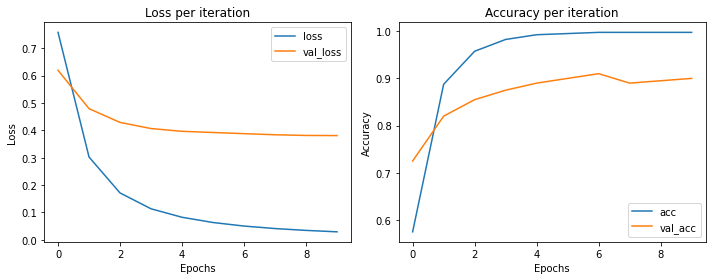

In [30]:
# let's do the same thing but with logistic regression in Tensorflow
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# train the model
r2 = linearmodel.fit(
    X_train2, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid2, Y_valid),
)

# Ploting loss and Accuracy per iteration
plotLossAndAccuracy(r2)

In [31]:
# Transfer learning with data augmentation takes a bit longer to process the
# data-It has a slow traing because the data has to pass through the entire CNN

# Transfer learning without data augmentation training is pretty fast since the 
# data only pass through stage 2 on the CNN

# We get a slightly better result with data augmentation
# with accuray 89.5 percent.

# ---- without augentation -----
# as a first approach without augentation, sing the Logistic Regression 
# from scikit-learn. We get a high score both on training (100 percent) 
# and test data (92 percent accuracy)
# As a second approach, using perform Logistic Regression in TensorFlow
# we get about the same value of accuracy 

In [32]:
# ----------------------------------------------------------------------------*
#  Inception v3:  
# We are going to use all the layers in the model
# • Model 3: Perform Transfer Learning with Augmentation 
# ----------------------------------------------------------------------------*
# create Inception V3 instance
ptm_InceptionV3 = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + [3])

# let's build model 2 using inception v3 instance
model3 = performTransferLearning(IMAGE_SIZE, ptm_InceptionV3, augmentation=True)

# view the structure of the model
model3.summary()

87924736/87910968 [==============================] - 0s 0us/step
-- Perform Transfer Learning with Augmentation --
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_norma

In [33]:
# create an instance of ImageDataGenerator
# this is where we are aolso doing some of the preprocessing
# using a batch size of 128
instance = imageDataGenerator(IMAGE_SIZE, 128, model3, augmentation=True)
gen_train = instance[0] 
gen_test = instance[1]
train_generator = instance[2]
valid_generator = instance[3]

-- create an instance of ImageDataGenerator with Augmentation --
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Epoch 1/10
4/4 [==============================] - 9s 1s/step - loss: 46.4424 - accuracy: 0.4525 - val_loss: 64.6976 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 3s 1s/step - loss: 37.3347 - accuracy: 0.5700 - val_loss: 30.9772 - val_accuracy: 0.5950
Epoch 3/10
4/4 [==============================] - 3s 823ms/step - loss: 33.4092 - accuracy: 0.5875 - val_loss: 40.5743 - val_accuracy: 0.5250
Epoch 4/10
4/4 [==============================] - 3s 843ms/step - loss: 25.4220 - accuracy: 0.6025 - val_loss: 15.7314 - val_accuracy: 0.6000
Epoch 5/10
4/4 [==============================] - 3s 825ms/step - loss: 15.4270 - accuracy: 0.6500 - val_loss: 14.6370 - val_accuracy: 0.5950
Epoch 6/10
4/4 [==============================] - 3s 836ms/step - loss: 16.6985 - accuracy: 0.6300 - val_loss: 16.2174 - val_accuracy: 0.6200
Epoch 7/10
4/4 [==============================] - 3s 817ms/step - loss: 13.9595 - accuracy: 0.6350 - val_loss: 11.9567 - val_accuracy: 0.6200
Epoch 8/10
4

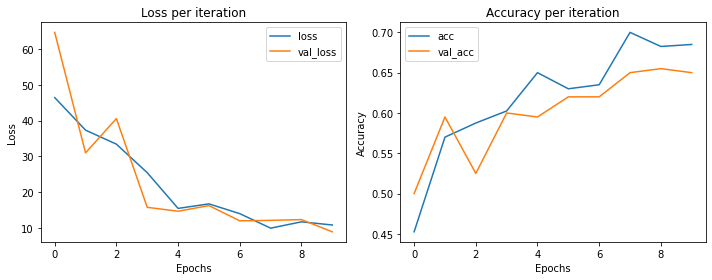

In [34]:
# Now let's train our model
# fit the model
# using a batch size of 128 and 10 epochs
r3 = trainModel(model3, 10, train_generator, valid_generator, 
                image_files, valid_image_files, 128)

# Ploting loss and Accuracy per iteration
plotLossAndAccuracy(r3)

In [35]:
# ----------------------------------------------------------------------------*
#  Inception v3:  
# We are going to use all the layers in the model
# • Model 4: Perform Transfer Learning without Augmentation  
# ----------------------------------------------------------------------------*
# let's build model 2 using the same inception v3 instance
model4 = performTransferLearning(IMAGE_SIZE, ptm_InceptionV3, augmentation=False)

# view the structure of the model
model4.summary()

-- Perform Transfer Learning without Augmentation --
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________

In [36]:
# create an instance of ImageDataGenerator
# this is where we are aolso doing some of the preprocessing
# using a batch size of 128
instance4 = imageDataGenerator(IMAGE_SIZE, 128, model4)
train_generator4 = instance4[0]
valid_generator4 = instance4[1]

-- create an instance of ImageDataGenerator without Augmentation --
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [37]:
# Number of training and testing images
Ntrain4 = len(image_files)
Nvalid4 = len(valid_image_files)

# Figure out the output size or the shape of what i'm getting out
# before flattening
feat4 = model4.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D4 = feat4.shape[1]

# let's creat the features and targets
X_train4 = np.zeros((Ntrain4, D4))
Y_train4 = np.zeros(Ntrain4)
X_valid4 = np.zeros((Nvalid4, D4))
Y_valid4 = np.zeros(Nvalid4)

In [38]:
# right now X_train and Y_train are just a bunch of 0s
# let's populate X_train and Y_train
populate(train_generator4, model4, X_train4, Y_train4, Ntrain4)

128
256
384
400
breaking now
400


In [39]:
# populate X_valid and Y_valid
populate(valid_generator4, model4, X_valid4, Y_valid4, Nvalid4)

128
200
breaking now
200


In [40]:
# let's check the value to see if normalization is going to 
# be helpfull or needed
X_train4.max(), X_train4.min()

(654.4114990234375, 0.0)

In [41]:
#let's now normalized the X-features data
# after normalization the mean bcome 0
# and the devioation become 1
scaler = StandardScaler()
X_train4_n = scaler.fit_transform(X_train4)
X_valid4_n = scaler.transform(X_valid4)

# let's check again
X_train4_n.max(), X_train4_n.min()

(19.974984355438252, -1.9371153399464431)

In [42]:
# Now let's try the scikit-learn logistic regression
# we are getting a high accuray from logistic regression 
# because of the power of VVG -- just running the image VVG helped

# using the the default max_iter is 100 resolves the warning:
# STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
# Explicitly specifying the max_iter to 1000 to resolves the warning
logr = LogisticRegression(max_iter=1000)
logr.fit(X_train4_n, Y_train4)
print(logr.score(X_train4_n, Y_train4))
print(logr.score(X_valid4_n, Y_valid4))

1.0
0.635


Epoch 1/10
4/4 [==============================] - 1s 102ms/step - loss: 0.8708 - accuracy: 0.5500 - val_loss: 1.0017 - val_accuracy: 0.5500
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 0.5382 - accuracy: 0.7425 - val_loss: 1.0080 - val_accuracy: 0.5950
Epoch 3/10
4/4 [==============================] - 0s 11ms/step - loss: 0.3821 - accuracy: 0.8250 - val_loss: 0.9429 - val_accuracy: 0.6000
Epoch 4/10
4/4 [==============================] - 0s 12ms/step - loss: 0.3376 - accuracy: 0.8650 - val_loss: 0.9355 - val_accuracy: 0.6500
Epoch 5/10
4/4 [==============================] - 0s 11ms/step - loss: 0.2735 - accuracy: 0.8800 - val_loss: 0.8360 - val_accuracy: 0.6250
Epoch 6/10
4/4 [==============================] - 0s 12ms/step - loss: 0.1973 - accuracy: 0.9350 - val_loss: 0.9094 - val_accuracy: 0.6100
Epoch 7/10
4/4 [==============================] - 0s 13ms/step - loss: 0.1531 - accuracy: 0.9525 - val_loss: 0.9902 - val_accuracy: 0.6150
Epoch 8/10
4/4 [==========

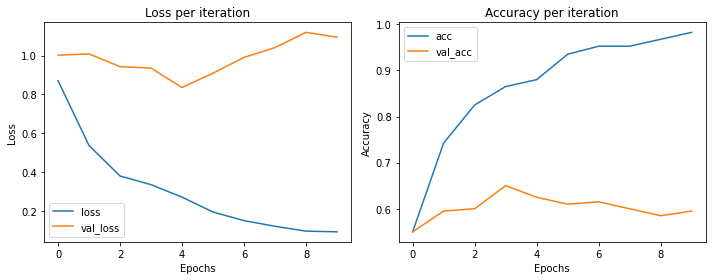

In [43]:
# let's do the same thing but with logistic regression in Tensorflow
i = Input(shape=(D4,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# Now let's train our model
# fit the model
# using a batch size of 128 and 10 epochs
# train the model
r4 = linearmodel.fit(
    X_train4_n, Y_train4,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid4_n, Y_valid4)
)

# Ploting loss and Accuracy per iteration
plotLossAndAccuracy(r4)

In [45]:
# performing transfer learning with Inception v3

# We get a bad result with data augmentation
# with accuray of about 68 percent and 98 percent without augmentation

# using the scikit-learn logistic regression result in a very low accuracy
# about 64 percent

# the large differnece gap betwwen the train and validation accuracy 
# accross all the approaches used and for both case of data augementation
# indicate that the model constracted with Inception v3 is overfitting 
# running the dataset through all the layers in the model as shown on
# the model.summary().